# High-Resolution Time Delay Estimation Between Noisy Signals

## Time-Domain Techniques

### Cross-Correlation and Parabolic Peak Interpolation

#### Problem statement

The cross-correlation between two signals $x(t)$ and $y(t)$ (with $y$ being a delayed version of $x$ plus noise)

which, in discrete form, becomes a sum over time shifts. The delay that maximizes $R_{xy}(/tau)$ is the estimated time difference of arrival. In practice, one computes the discrete cross-correlation (using xcorr or FFT methods) and finds the index $k_0$ of the peak. This $k_0$ gives the nearest integer-sample delay. To achieve fractional delay estimates, we can interpolate around this peak.

#### Parabolic Peak Interpolation

A common approach is parabolic interpolation using the correlation values at the peak and its immediate neighbors. Assuming $R_{xy}(k_0)$ is the maximum at integer lag $k_0$, with neighbors $R_{xy}(k_0-1)$ and $R_{xy}(k_0+1)$, we fit a quadratic through these three points and find its vertex. If we denote $y(-1)=R_{xy}(k_0-1)$, $y(0)=R_{xy}(k_0)$, $y(1)=R_{xy}(k_0+1)$, the fractional offset $/delta$ from $k_0$ that maximizes the parabola is

In [ ]:
# x, y: input signals (1D arrays), assume len(y) ≈ len(x)
import numpy as np

roi_df = np.load("data/example/highspeed_roi/sid101-rid1-qhy5iii174c-seg1-roi.pkl")

# Compute cross-correlation (full mode to get negative and positive lags)
corr = np.correlate(y, x, mode='full')  
lags = np.arange(-len(x)+1, len(y))    # corresponding lag values

# Find index of max correlation
k0 = np.argmax(corr)
peak_lag = lags[k0]        # integer lag of max correlation

# Parabolic interpolation around the peak
if 0 < k0 < len(corr)-1:
    y_m1, y_0, y_p1 = corr[k0-1], corr[k0], corr[k0+1]
    denom = (y_m1 - 2*y_0 + y_p1)
    if denom != 0:
        delta = (y_m1 - y_p1) / (2 * denom)
    else:
        delta = 0.0
else:
    delta = 0.0

frac_delay = peak_lag + delta   # estimated fractional delay (in samples)


In [21]:
import numpy as np
roi_df = np.load("data/example/highspeed_roi/sid101-rid1-qhy5iii174c-seg1-roi.pkl", allow_pickle=True)
x = roi_df['roi-forehead'].to_list()
y = roi_df['roi-right_cheek'].to_list()

x = np.array(x)
y = np.array(y)

x = x[:,[2,1,0]]
y = y[:,[2,1,0]]

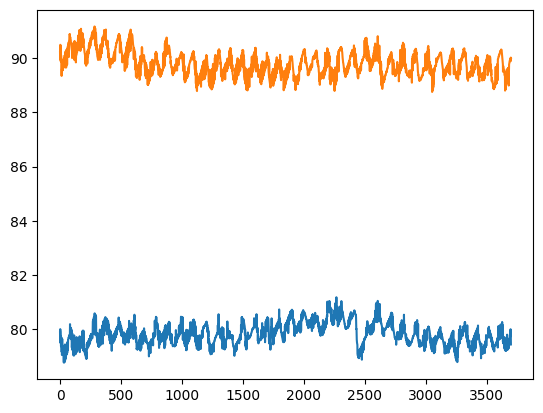

In [13]:
import matplotlib.pyplot as plt
plt.plot(x)
plt.plot(y)